In [19]:
import rasterio as rio
import numpy as np
from rasterio.enums import Resampling
from rasterio import warp
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import seaborn as sns
import ee
import geemap
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [3]:
ee.Authenticate()
project_id = 'ee-tut-452819'
ee.Initialize(project=project_id)

This notebook will compare the HAND model and a Random Forest Model

In [4]:
# Read HAND model (lower resolution)
with rio.open('data/mosacied_wo_thresh.tif') as hand_tif:
    hand = hand_tif.read(1)
    hand_meta = hand_tif.meta  # Get the metadata for HAND model

# Read ground truth (higher resolution)
with rio.open('data/SAR_flooding.tif') as gt_tif:
    ground_truth = gt_tif.read(1)

In [5]:
print(hand_tif.shape)  # Should print the shape of your HAND model
print(ground_truth.shape)  # Should print the shape of your ground truth

(7212, 7212)
(2499, 3909)


In [6]:
transform = hand_tif.transform
kwargs = hand_meta.copy()
kwargs.update({
    'count': 1,
    'height': hand.shape[0],  # Same as HAND
    'width': hand.shape[1],   # Same as HAND
    'crs': hand_tif.crs
})

In [7]:
resampled_ground_truth = np.zeros_like(hand, dtype=np.float32)

In [8]:
with rio.open('data/SAR_flooding.tif') as gt_tif:
    rio.warp.reproject(
        source=ground_truth,
        destination=resampled_ground_truth,
        src_transform=gt_tif.transform,
        src_crs=gt_tif.crs,
        dst_transform=transform,
        dst_crs=hand_tif.crs,
        resampling=Resampling.nearest
    )

# Now, resampled_ground_truth should match the HAND model's resolution
print(f'Resampled Ground Truth shape: {resampled_ground_truth.shape}')


Resampled Ground Truth shape: (7212, 7212)


Determine optimal threshold for flooding in the HAND model

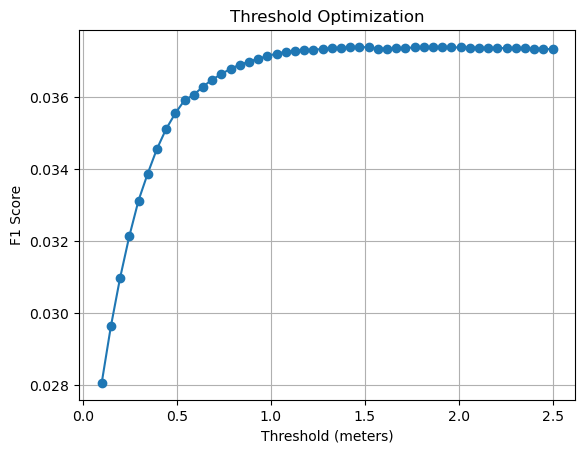

Best threshold is 1.47 meters (F1 = 0.037)


In [9]:
# Apply valid mask to ignore NaNs (masked areas) from ground truth
valid_mask = ~np.isnan(resampled_ground_truth)

# Flatten arrays for sklearn (f1_score)
hand_flat = hand[valid_mask].flatten()
ground_flat = resampled_ground_truth[valid_mask].flatten()

# Thresholds to try for F1 score calculation
thresholds = np.linspace(0.1, 2.5, 50)

f1_scores = []

# Iterate through thresholds and calculate F1 score
for thres in thresholds:
    prediction = (hand_flat <= thres).astype(int)  # Predict flooded if hand <= threshold
    f1 = f1_score(ground_flat, prediction)
    f1_scores.append(f1)

# Plot F1 score vs Threshold
plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel('Threshold (meters)')
plt.ylabel('F1 Score')
plt.title('Threshold Optimization')
plt.grid(True)
plt.show()

# Find the best threshold based on the highest F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'Best threshold is {best_threshold:.2f} meters (F1 = {max(f1_scores):.3f})')

In [32]:

aoi = ee.FeatureCollection("projects/ee-tut-452819/assets/HCAD_Harris_County_Boundary").geometry()
flooding_change_detection = ee.Image('projects/ee-tut-452819/assets/flood_extent_houston')
hand_inundation = ee.Image('projects/ee-tut-452819/assets/HAND_no_threshold')
hand_inundation = hand_inundation.gte(best_threshold)
hand_inundation = hand_inundation.clip(aoi)
flooded_change_detection = flooding_change_detection.clip(aoi).gt(0)

Validate the HAND Model

In [11]:
image = flooding_change_detection.unmask()
image3 = hand_inundation
table = aoi

# Apply the threshold
threshold = 1.37
image3_binary = image3  # No masking for binary image

# Check the distribution of values in image3_binary
binary_values = image3_binary.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=table,
    scale=30,
    maxPixels=1e8
).getInfo()

print("Binary value distribution:", binary_values)

# Define the region for sampling
region = table

# Create binary ground truth (0 = no flood, 1 = flood)
binary_flood = image.eq(1)
binary_not_flood = image.eq(0)
classification = binary_flood.multiply(1).add(binary_not_flood.multiply(0)).rename('class')

# Take stratified sample (equal flood and non-flood points)
stratified_sample = classification.stratifiedSample(
    numPoints=500,
    region=region,
    scale=30,
    seed=123,
    classValues=[0, 1],
    classPoints=[250, 250],
    geometries=True
)

# Stack the true and predicted images
stacked = classification.addBands(image3_binary.rename('predicted'))

# Sample both ground truth and prediction at the same points
sample = stacked.sampleRegions(
    collection=stratified_sample,
    scale=30,
    geometries=True
)

# Get the sample data
sample_data = sample.getInfo()['features']

# Print the first feature to check property names
if len(sample_data) > 0:
    print("Available properties:", sample_data[0]['properties'].keys())

# Extract ground truth and predicted values
y_true = []
y_pred = []

for feature in sample_data:
    props = feature['properties']
    y_true.append(props['class'])
    y_pred.append(props['predicted'])

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)




Binary value distribution: {'b1': {'0': 4315307.270588238, '1': 1603954.2705882348}}
Available properties: dict_keys(['class', 'predicted'])


In [12]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Handle case where confusion matrix doesn't have all categories
if cm.shape != (2, 2):
    print("Warning: Confusion matrix doesn't have all categories")
    full_cm = np.zeros((2, 2))
    for i in range(min(2, cm.shape[0])):
        for j in range(min(2, cm.shape[1])):
            full_cm[i, j] = cm[i, j]
    cm = full_cm

tn, fp, fn, tp = cm.ravel()

# Print results
print("\nConfusion Matrix:")
print(cm)
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print("\nClassification Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall/Sensitivity: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")


Confusion Matrix:
[[182  68]
 [186  64]]
True Negatives: 182
False Positives: 68
False Negatives: 186
True Positives: 64

Classification Metrics:
Accuracy: 0.4920
Precision: 0.4848
Recall/Sensitivity: 0.2560
Specificity: 0.7280
F1 Score: 0.3351


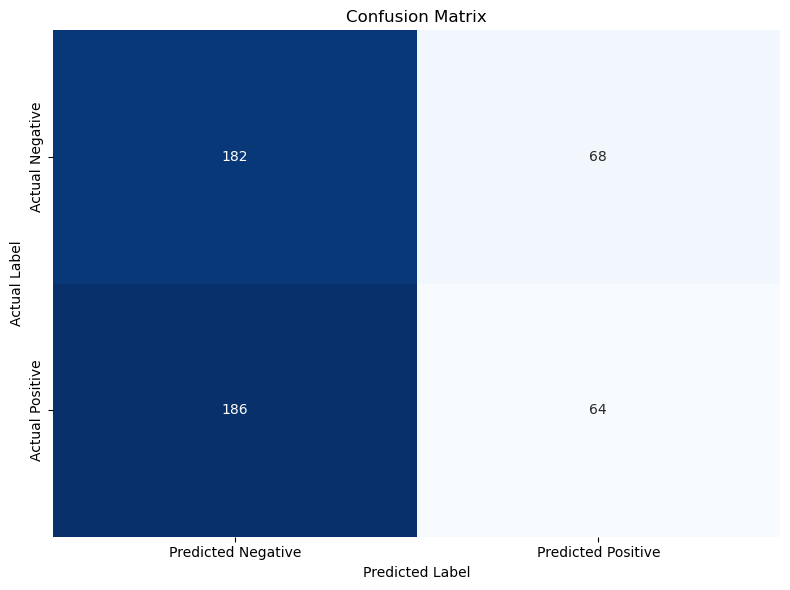

In [13]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


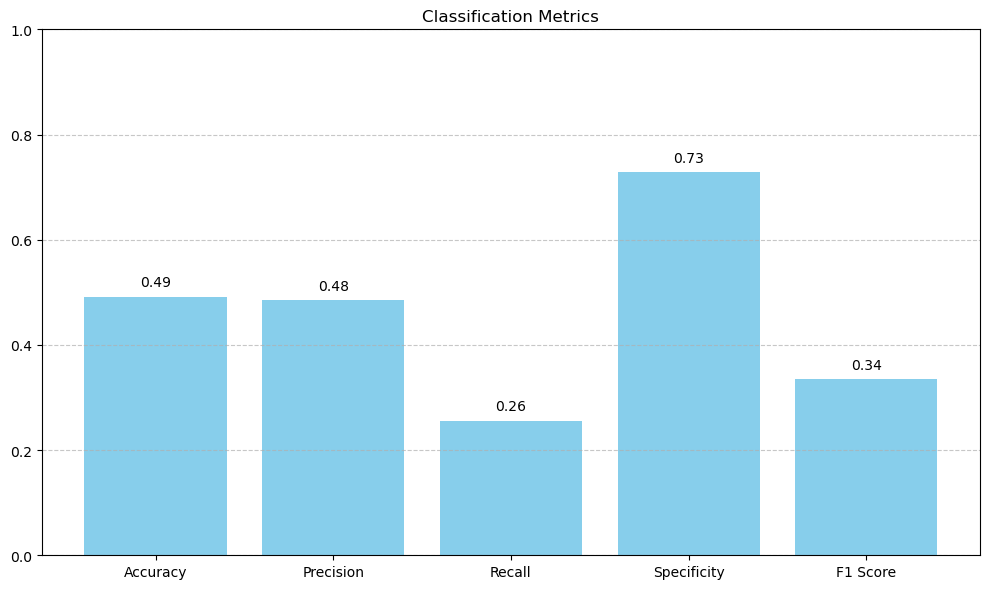

In [14]:
# Create a bar chart of the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score']
values = [accuracy, precision, recall, specificity, f1]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)
plt.title('Classification Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

In [17]:
true_positive = hand_inundation.And(flooded_change_detection)
# true positive

In [28]:
true_positive.bandNames()

In [31]:
# Compute difference (hand inundation flooded but Sentinel-1 not) = false positive
false_positive = hand_inundation.And(flooded_change_detection.Not())

In [29]:
false_positive.bandNames()

In [23]:
# Compute difference (Sentinel-1 flooded but HAND not) = False Negative
false_negative = flooded_change_detection.And(hand_inundation.Not())

In [22]:
true_negative = flooded_change_detection.Not().And(hand_inundation.Not())

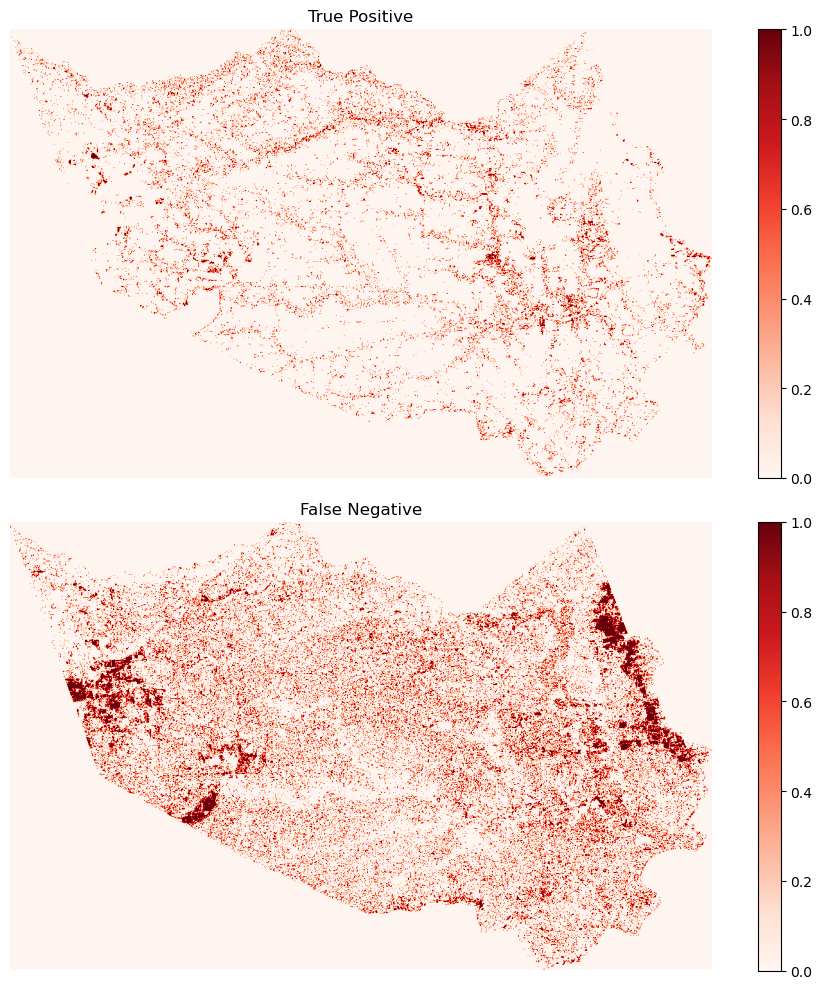

In [37]:

arrays = {
    "True Positive": geemap.ee_to_numpy(true_positive.clip(aoi), region=aoi, scale=100, bands=['b1']),
    #"False Positive": geemap.ee_to_numpy(false_positive.clip(aoi), region=aoi, scale=100, bands=['VH']),
    "False Negative": geemap.ee_to_numpy(false_negative.clip(aoi), region=aoi, scale=100, bands=['VH']),
    #"True Negative": geemap.ee_to_numpy(true_negative.clip(aoi), region=aoi, scale=100, bands=['VH']),
}

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

for ax, (title, arr) in zip(axes.flat, arrays.items()):
    img = ax.imshow(arr.squeeze(), cmap='Reds') 
    ax.set_title(title)
    ax.axis('off')
    fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

Create Random Forest Model

In [38]:
after_start = '2017-08-28'
after_end = '2017-09-05'

# RF model
flood_truth = flooding_change_detection.unmask()
precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filterDate(after_start, after_end).sum().clip(aoi)  # total precipitation over flood month

# Land Cover (static, 2020)
landcover = ee.Image('ESA/WorldCover/v100/2020').clip(aoi)

In [39]:
target_proj = flood_truth.projection().atScale(100)

precip_band = precip.resample('bicubic').reproject(target_proj)
precip_band = precip_band.updateMask(precip_band.gt(-1)).clip(table)

# Reproject and resample land cover
landcover_band = landcover.reproject(crs=target_proj)

In [43]:
precip_band = precip_band.rename('precip')
landcover_band = landcover_band.rename('landcover')

# Stack into a single multi-band image
flood_truth_int = flood_truth.toInt().rename('class').gt(0)

# Add the class band to the features image
features = precip_band.addBands(landcover_band).addBands(flood_truth_int)

In [45]:
flood_truth_int.getInfo()  # Check the properties of the flood truth image

{'type': 'Image',
 'bands': [{'id': 'class',
   'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 1},
   'dimensions': [3909, 2499],
   'crs': 'EPSG:4326',
   'crs_transform': [0.00026949458523585647,
    0,
    -95.96082342702806,
    0,
    -0.00026949458523585647,
    30.17072730090984]}],
 'properties': {'system:footprint': {'type': 'LinearRing',
   'coordinates': [[-95.96099119322174, 30.170659548403794],
    [-95.96100095234705, 30.170615048848298],
    [-95.96099885534478, 29.49739508312663],
    [-95.96087271272694, 29.49727056029062],
    [-95.96075866841232, 29.497125035870535],
    [-95.69739246322757, 29.497125118657546],
    [-95.43409623565395, 29.49712511450371],
    [-95.17080006441664, 29.497125134713116],
    [-94.9075041886769, 29.497125105099116],
    [-94.90736099023412, 29.497234739150787],
    [-94.9071936354415, 29.4973338717609],
    [-94.90719157618074, 30.17059258010537],
    [-94.90731837926424, 30.170716838915013],
    [-94.90742601558

In [ ]:
stratified_sample = features.stratifiedSample(
numPoints= 5000, #2
classBand= 'class',
region= aoi,
scale= 100,
classValues= [0, 1],
classPoints= [2500, 2500],
seed= 123,
geometries= True,
dropNulls= True,
tileScale= 16  # Try increasing tileScale if you're hitting computation limits
)

In [ ]:
trainingData = features.sampleRegions( #2
collection= stratified_sample,
properties= ['class'],
scale= 100,
tileScale= 16
)

In [55]:
classifier = ee.Classifier.smileRandomForest(numberOfTrees=100).train( #2
features= trainingData,
classProperty= 'class',
inputProperties= ['precip', 'landcover']
)

print(classifier.explain())

ee.Dictionary({
  "functionInvocationValue": {
    "functionName": "Classifier.explain",
    "arguments": {
      "classifier": {
        "functionInvocationValue": {
          "functionName": "Classifier.train",
          "arguments": {
            "classProperty": {
              "constantValue": "class"
            },
            "classifier": {
              "functionInvocationValue": {
                "functionName": "Classifier.smileRandomForest",
                "arguments": {
                  "numberOfTrees": {
                    "constantValue": 100
                  }
                }
              }
            },
            "features": {
              "functionInvocationValue": {
                "functionName": "Image.sampleRegions",
                "arguments": {
                  "collection": {
                    "functionInvocationValue": {
                      "functionName": "Image.stratifiedSample",
                      "arguments": {
                        "

In [58]:
classified = features.classify(classifier) #2
classified.bandNames()


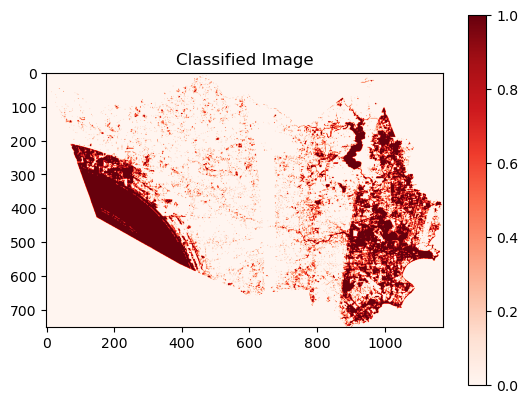

In [60]:

array = geemap.ee_to_numpy(classified, region=aoi, scale=100, bands=['classification'])

# Plot it
plt.imshow(array, cmap='Reds')
plt.title("Classified Image")
plt.colorbar()
plt.show()

Validate the Random Forest Model

In [61]:
image = flooding_change_detection.unmask()
image3 = classified
table = aoi

# Apply the threshold
threshold = 1.37
image3_binary = image3  # No masking for binary image

# Check the distribution of values in image3_binary
binary_values = image3_binary.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=table,
    scale=30,
    maxPixels=1e8
).getInfo()

print("Binary value distribution:", binary_values)

# Define the region for sampling
region = table

# Create binary ground truth (0 = no flood, 1 = flood)
binary_flood = image.eq(1)
binary_not_flood = image.eq(0)
classification = binary_flood.multiply(1).add(binary_not_flood.multiply(0)).rename('class')

# Take stratified sample (equal flood and non-flood points)
stratified_sample = classification.stratifiedSample(
    numPoints=500,
    region=region,
    scale=30,
    seed=123,
    classValues=[0, 1],
    classPoints=[250, 250],
    geometries=True
)

# Stack the true and predicted images
stacked = classification.addBands(image3_binary.rename('predicted'))

# Sample both ground truth and prediction at the same points
sample = stacked.sampleRegions(
    collection=stratified_sample,
    scale=30,
    geometries=True
)

# Get the sample data
sample_data = sample.getInfo()['features']

# Print the first feature to check property names
if len(sample_data) > 0:
    print("Available properties:", sample_data[0]['properties'].keys())

# Extract ground truth and predicted values
y_true = []
y_pred = []

for feature in sample_data:
    props = feature['properties']
    y_true.append(props['class'])
    y_pred.append(props['predicted'])

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)



Binary value distribution: {'classification': {'0': 4294067.011764703, '1': 1618334.3176470583}}
Available properties: dict_keys(['class', 'predicted'])


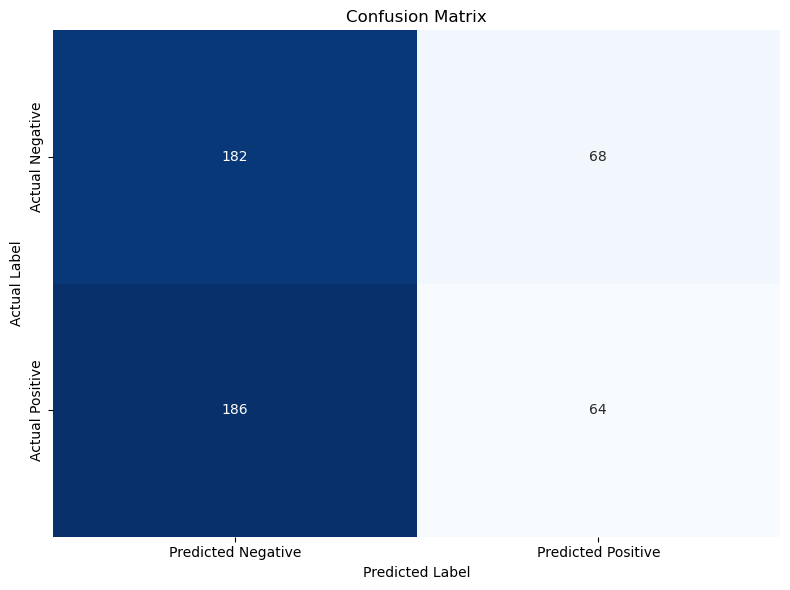

In [62]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


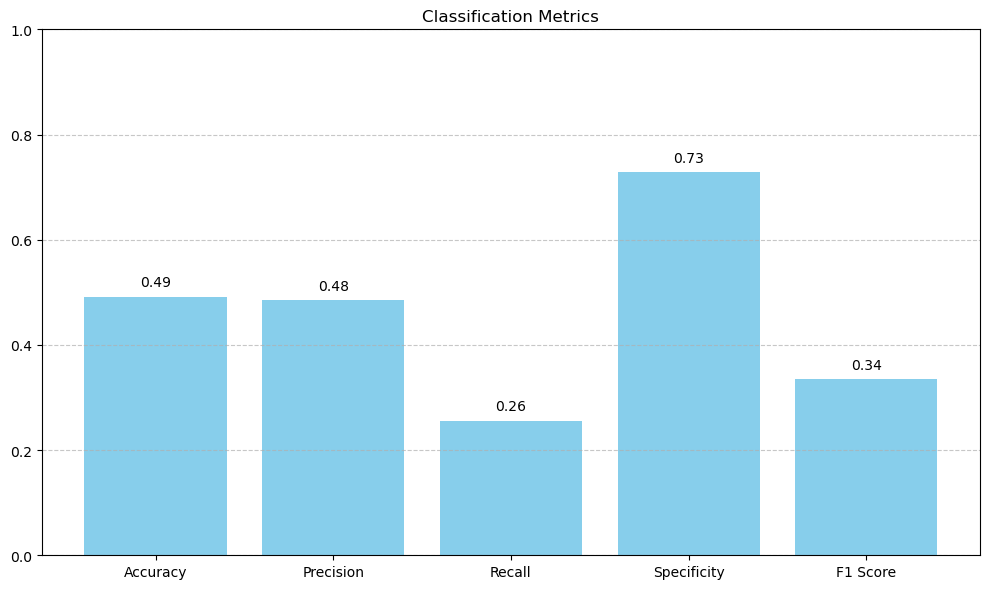

In [63]:
# Create a bar chart of the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score']
values = [accuracy, precision, recall, specificity, f1]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)
plt.title('Classification Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

In [ ]:
true_positive = classified.And(flooded_change_detection)

In [ ]:
false_positive = classified.And(flooded_change_detection.Not())


In [ ]:
false_negative = flooded_change_detection.And(classified.Not())

In [ ]:
true_negative = flooded_change_detection.Not().And(classified.Not())

In [64]:
true_negative.bandNames()

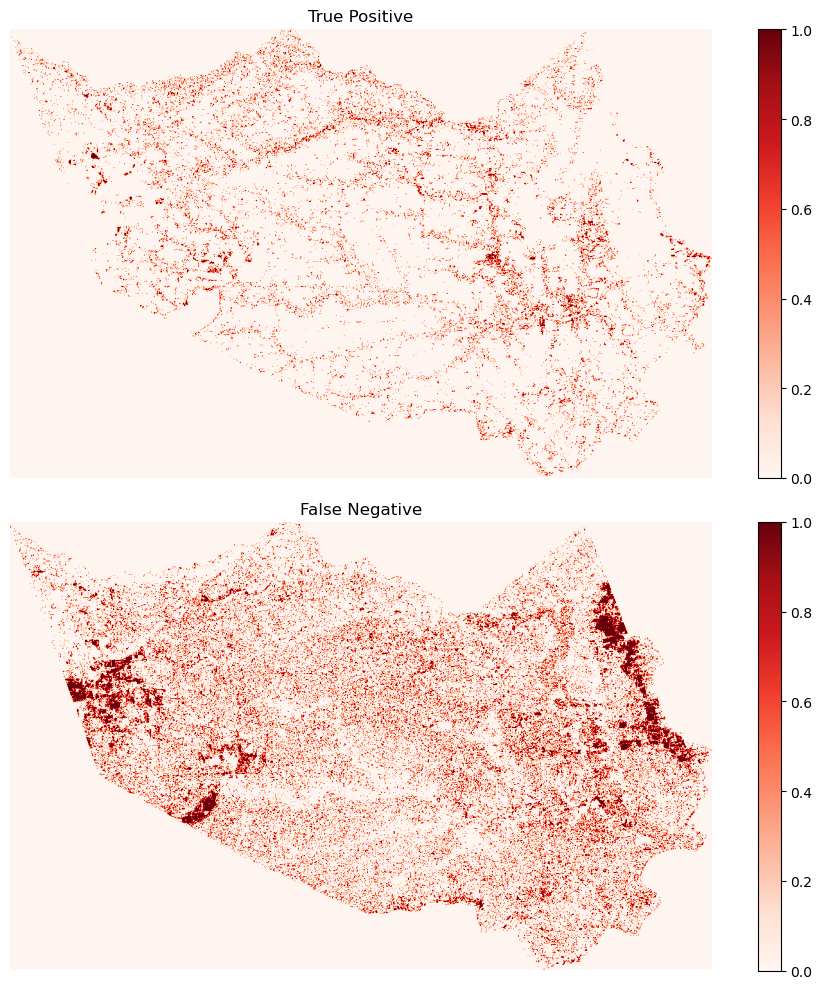

In [67]:
arrays = {
    "True Positive": geemap.ee_to_numpy(true_positive.clip(aoi), region=aoi, scale=100, bands=['b1']),
    #"False Positive": geemap.ee_to_numpy(false_positive.clip(aoi), region=aoi, scale=100, bands=['b1']),
    "False Negative": geemap.ee_to_numpy(false_negative.clip(aoi), region=aoi, scale=100, bands=['VH']),
    #"True Negative": geemap.ee_to_numpy(true_negative.clip(aoi), region=aoi, scale=100, bands=['VH']),
}

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

for ax, (title, arr) in zip(axes.flat, arrays.items()):
    img = ax.imshow(arr.squeeze(), cmap='Reds') 
    ax.set_title(title)
    ax.axis('off')
    fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()